In [72]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## Load the genome annotation & Regprecise2k expression set for E. Coli

In [21]:
annotation = pd.read_csv("../data/Annotation/gene_info.csv", index_col=0)
annotation.head()

,gene_name,old_locus_tag,start,end,strand,gene_product,COG,uniprot
locus_tag,,,,,,,,
b0001,thrL,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86
b0002,thrA,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561
b0003,thrB,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547
b0004,thrC,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934
b0005,yaaX,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616


In [23]:
norm_expr = pd.read_csv("../data/RNAseq/log_tpm_norm_qc.csv", index_col=0)
norm_expr.head()

,ecoli_00001,ecoli_00002,ecoli_00003,ecoli_00004,ecoli_00005,ecoli_00006,ecoli_00007,ecoli_00008,ecoli_00009,ecoli_00010,...,ecoli_00836,ecoli_00837,ecoli_00838,ecoli_00839,ecoli_00840,ecoli_00841,ecoli_00842,ecoli_00843,ecoli_00844,ecoli_00845
Geneid,,,,,,,,,,,,,,,,,,,,,
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,0.428330,0.411415,0.676890,0.717977,0.566652,0.494059,0.391764,0.354140,0.511783,0.511414
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,0.118813,0.136150,0.283553,0.312617,0.218052,0.178959,-0.003172,0.009862,0.243692,0.078913
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,0.068482,0.001423,0.073893,0.129509,0.120244,0.024783,-0.078807,-0.100213,0.111615,0.055444
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-0.796283,-0.886118,-0.894796,-0.951029,-0.670444,-0.679904,-0.762858,-0.769622,-0.555832,-0.888623
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.022882,0.131379,0.000451,-0.026216,0.064733,-0.022189,0.080494,0.105803,0.089802,0.256373


## Load and preprocess the PRECISE2 RNA-seq gene expression dataset

### From the methods:  

__Regulatory networks and module definitions__  
For E. coli datasets, we used a regulatory network from the RegulonDB database version 8 (regulondb.ccg.unam.mx, accessed 03/06/2015), a database integrating both small-scale experimental evidence as well as genome-wide data of transcriptional regulation [38]. We only included interactions with at least one strong evidence type (APPH, BPP, FP, IDA, SM, TA, CHIP-SV, GEA, ROMA, and gSELEX). We did not group the regulatory interactions at operon level, as we found that this has only minimal impact on the overall ranking of the different methods (Supplementary Fig. 17a). We also did not include sigma factor regulations as we found that this would have a negligible effect on performance (Supplementary Fig. 17b).

### 
### RegulonDB Release: 10.9 Date: 06/29/2021
Columns:  
(1) Transcription Factor (TF) ID  
(2) Transcription Factor (TF) Name  
(3) Gene ID regulated by the TF (regulated gene)  
(4) Gene regulated by the TF (regulated gene)  
(5) Regulatory effect of the TF on the regulated gene (+ activator, - repressor, +- dual, ? unknown)  
(6) Evidence that supports the existence of the regulatory interaction  
(7) Evidence Type [Weak, Strong, Confirmed] For details see: https://regulondb.ccg.unam.mx/manual/help/evidenceclassification

| tf_id | tf_name | target_id | target_name | effect | evidence | evidence_type |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  ECK125286586   |  AccB   |  ECK120000269   |  accB   |  -   |  []   |  null   |
|  ECK125286586   |  AccB   |  ECK120000270  |  accC   |  -   |  []   |  null  |
|  ECK120015994   |  AcrR   |  ECK120001646   |  acrA   |  -   |  []   |  null   |




In [33]:
# downloaded from https://regulondb.ccg.unam.mx/datasets –NetworkRegulatorGene
regdb = pd.read_csv("../data/Regulatory/NetworkRegulatorGene.tsv", sep='\t', skiprows=24)
# replace the number prepending columns ex 1)
regdb.columns = regdb.columns.str.replace(r'^\d+\)\s*', '', regex=True).str.strip()
print(f"Total number of identified regulatory interactions: {regdb.shape[0]}")
regdb.head()


Total number of identified regulatory interactions: 7127


,regulatorId,regulatorName,RegulatorGeneName,regulatedId,regulatedName,function,confidenceLevel
0,RDBECOLICNC00063,ppGpp,NaN,RDBECOLIGNC00006,hisM,-,W
1,RDBECOLICNC00063,ppGpp,NaN,RDBECOLIGNC00030,agp,+,W
2,RDBECOLICNC00063,ppGpp,NaN,RDBECOLIGNC00039,cysQ,+,W
3,RDBECOLICNC00063,ppGpp,NaN,RDBECOLIGNC00065,argI,+,W
4,RDBECOLICNC00063,ppGpp,NaN,RDBECOLIGNC00067,argS,-,W


# In the updated database this formatting has changed:
(1) regulatorId	– corresponds to tf_id  
(2) regulatorName – New column allowing for the inclusion of non-protein regulators  
(3) RegulatorGeneName – corresponds to tf_name  
(4) regulatedId – corresponds to target_id  
(5) regulatedName – corresponds to target_name  
(6) function – corresponds to effect  
(7) confidenceLevel  – corresponds to evidence type 

### Modify the database so that it is in the same format as was originally described in the paper

In [56]:
# Remove ppGpp as a regulator as it is not a TF
missing_gene_name_mask = regdb['RegulatorGeneName'].isna()
print(f"metabolic regulators of expression: {regdb[missing_gene_name_mask]['regulatorName'].unique()}")

# Filter the dataset so that all tfs are proteins (ie has a gene name)
prot_reg = regdb[~missing_gene_name_mask]
print(f"Number of interactions after excluding ppGpp {prot_reg.shape[0]}")

# Filter to exclude weak evidence
strong_evidence = prot_reg[(~prot_reg.confidenceLevel.str.contains("W")) &
                           (prot_reg.confidenceLevel != "? ")]
print(f"Number of interactions after excluding weak evidence {strong_evidence.shape[0]}")
print(f'{strong_evidence.confidenceLevel.value_counts()}\n')


regnet = strong_evidence.query("regulatedName in @annotation.gene_name")
print(f"After filtering for genes which are defined in the precise2k dataset: {regnet.shape[0]}")
regnet.head()

metabolic regulators of expression: ['ppGpp']
Number of interactions after excluding ppGpp 6819
Number of interactions after excluding weak evidence 4377
S     3011
C     1366
Name: confidenceLevel, dtype: int64

After filtering for genes which are defined in the precise2k dataset: 4131


,regulatorId,regulatorName,RegulatorGeneName,regulatedId,regulatedName,function,confidenceLevel
309,RDBECOLIPDC00328,DicF,dicF,RDBECOLIGNC00341,ftsZ,-,S
310,RDBECOLIPDC00328,DicF,dicF,RDBECOLIGNC00559,manX,-,S
311,RDBECOLIPDC00328,DicF,dicF,RDBECOLIGNC00793,pykA,-,S
312,RDBECOLIPDC00328,DicF,dicF,RDBECOLIGNC02444,xylR,-,S
313,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00450,hns,-,S


In [82]:
## Get regulons which are greater than 5 genes
tf_modules = {}
for tf_name, tf_regnet in regnet.groupby("regulatorName"):
    if tf_regnet.shape[0] > 5:
        tf_modules[tf_name] = tf_regnet["regulatedName"].tolist()

# get the number of genes in each regulon using a list comprehension
# convert this to a numpy array so we can do vectorized operations on it
reg_len = np.array([len(val) for val in tf_modules.values()])

In [103]:
# Use the keys from the dictionary to reselct the rows in the dataframe
regnet = regnet[regnet.regulatorName.isin(tf_modules.keys())]
regnet.to_csv("../data/Regulatory/QCd_Network.csv")

In [83]:
print(f"Number of TFs with associated modules: {len(tf_modules.values())}\n\
Average number of genes in a module: {round(reg_len.mean(),2)}\n\
Std. Dev. number of genes in a module: {round(reg_len.std(),2)}")

Number of TFs with associated modules: 130
Average number of genes in a module: 29.15
Std. Dev. number of genes in a module: 60.3


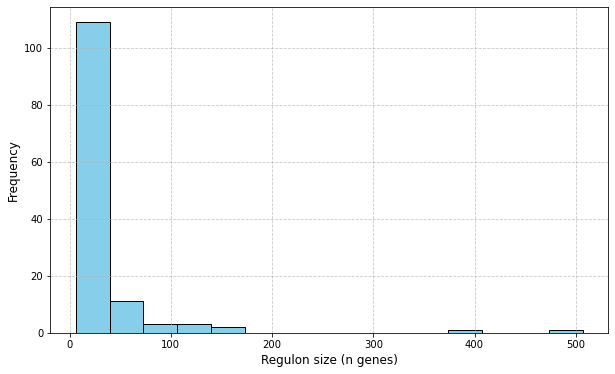

In [84]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
ax.hist(reg_len, bins=15, color='skyblue', edgecolor='black')

ax.set_xlabel('Regulon size (n genes)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## Next Step: Charecterization of module definitions

### From the methods:
For every gold standard, we obtained sets of known modules based on three different module definitions. We defined minimally co-regulated modules as overlapping groups of genes that shared at least one regulator. Strictly co-regulated modules were defined as groups of genes known to be regulated by exactly the same set of regulators. Strongly interconnected known modules, on the other hand, were defined as groups of genes that are strongly interconnected, and this does therefore not necessarily reflect co-regulation. We used three different graph cluster algorithms (markov clustering, transitivity clustering, and affinity propagation) with in every case three different parameter settings representing different levels of cluster compactness. For the Markov Clustering Algorithm42 we used inflation parameters 2, 10, and 50. For transitivity clustering43 we used two different cutoff parameters for the fuzzy membership 0.1 and 0.9. These two parameter settings allowed the modules to overlap (Supplementary Fig. 18). In the third parameter setting for transitivity clustering, we assigned every gene to the module with the highest fuzzy membership value. For affinity propagation44 we varied the preference value between 0.5, 2, and an automatically estimated value (see Supplementary Note 2). All known modules were then filtered for the genes present in the expression matrix. Finally, we filtered strongly overlapping known modules by merging two modules if they overlapped strongly (Jaccard coefficient > 0.8) and removed small modules by requiring at least five genes. The latter cutoff was defined based on where the average optimal performance of all methods reached a maximum.

__Definitions of modules:__
1) minimally co-regulated: at least one shared gene overlap
2) strictly co-regulated: groups of genes directly overlapping between two TFs
3) Strongly interconnected known modules

Strongly interconnected known modules is vague? How do we determine whether TF target sets are strongly co-regulated? In the paper they utilize graph clustering algorithms. Lets start by defining minimally co-regulated and strictly co-regulated.



In [ ]:
#min_co_reg = 
